# Importing libraries

In [1]:
import cv2 as cv

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
print(os.environ['CUDA_VISIBLE_DEVICES'])
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

0


InternalError: failed initializing StreamExecutor for CUDA device ordinal 0: Internal: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 12790923264

In [3]:
import os
import sys

import random
import warnings
import time
import pprint as pp
from keras import layers
from keras import models
from time import strftime, gmtime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Using TensorFlow backend.


# Checking whether it's a Jupyter notebook or not

In [4]:
from IPython import get_ipython

ip = get_ipython()

if ip == None:
    print('Python Script from notebook is running.')
    plt.switch_backend('agg')
else:
    print('Notebook is running.')

Notebook is running.


# Walking through the training image directory and collecting the class names (genus names for fossils)

In [5]:
import os

from os import walk
import copy

#scratch_dir = '/scratch/gilbreth/azehady/'
scratch_dir = '/home/azehady/projects/'
project_dir = 'automatic_fossil_image_detection/' 

os.chdir(scratch_dir + project_dir)

path = scratch_dir + project_dir + 'datapack_images/Global/Foram_TSCLite_Images'

file_names = None
tiny_file_names = []

for (dirpath, dirnames, fnames) in walk(path):
    file_names = fnames

single_image_file = []
multiple_image_file = []
genus_single = []
species_single = []
genus_multiple = []
species_multiple = []
morphospecies_names = []

for f in file_names:
    forig = copy.copy(f)
    if ' ' in f:
        f = f.split(' ')
    elif '_' in f:
        f = f.split('_')
    if 'tiny' in forig and len(f) != 2:
        tiny_file_names.append(forig)
        #print('single = ' + str(f))
        single_image_file.append(forig)
        genus_single.append(f[0])
        species_single.append(f[1])
        morphospecies_name = str(f[0]) + str(' ') + str(f[1]) 
        morphospecies_names.append(morphospecies_name)
    else:
        #print('multi = ' + str(f))
        multiple_image_file.append(forig)
        genus_multiple.append(f[0])
        fm = f[1].split('.')[0]
        species_multiple.append(fm)

        
        
'''

print(genus_single)
print(species_single)
print('')
print(genus_multiple)
print(species_multiple)

'''


for i, f in enumerate(single_image_file):
    s = str(genus_single[i]) + ', ' + str(f)
    #print(s)
    
print(len(genus_single))
print(genus_multiple)

236
['Globoconella', 'Planorotalites', 'Globoturborotalita', 'Tenuitella', 'Cribrohantkenina', 'Globotruncana', 'Globigerinoides', 'Globorotalia', 'Pulleniatina', 'Globorotalia', 'Fohsella', 'Acarinina', 'Globigerinoidesella', 'Paragloborotalia', 'Marginotruncana', 'Globorotalia', 'Praeorbulina', 'Globigerina', 'Neogloboquadrina', 'Acarinina', 'Praeorbulina', 'Globuligerina', 'Sphaeroidinellopsis', 'Globorotalia', 'Helvetoglobotruncana', 'Globorotalia', 'Globigerinatheka', 'Subbotina', 'Globorotalia', 'Clavatorella', 'Morozovella', 'Thalmanninella', 'Globigerinoides', 'Globuligerina', 'Gansserina', 'Dentoglobigerina', 'Parvularugoglobigerina', 'Chiloguembelina', 'Globigerina', 'Neogloboquadrina', 'Pseudohastigerina', 'Radotruncana', 'Morozovella', 'Biticinella', 'Morozovella', 'Globigerinelloides', 'Pseudothalmanninella', 'Catapsydrax', 'Globuligerina', 'Globorotalia', 'Fohsella', 'Morozovella', 'Abathomphalus', 'Orbulina', 'Globoturborotalita', 'Globuligerina', 'Paragloborotalia', 'Pa

# Creating different dictionaries and lists to track class names with different keys

multi_cls: Dict keyed by the unique genus name and for each genus name the index of the image file from 236 files

final_cls: Dict keyed by the unique genus names, values indicate the index of the first image file with the same genus

classes: Dict gives the unique genus/class id for 236 genus files, keyed from 0 to 236 (236 image files)

class_names: Dict gives the unique genus/class id for 236 genus files, keyed by the unique genus name

uniq_cls: list gives the unique genus names

In [6]:
# 79 different classes
cls = genus_single
file_names = single_image_file
multi_cls = {}
final_cls = {}
k = 0
for j, cl in enumerate(cls):
    if cl in multi_cls.keys():
        multi_cls[cl].append(j)
    else:
        a = [j]
        multi_cls[cl] = a
        final_cls[cl] = k
        k += 1
    
print(multi_cls)
print("")
print(final_cls)
print("")

classes = {}
class_names = {}
for k in multi_cls.keys():
    clss = multi_cls[k]
    for c in clss:
        classes[c] = final_cls[k]
        class_names[c] = k
     
print(classes)
print("")
print(class_names)

uniq_cls = uniq_genus = list(multi_cls.keys())

print("")
print(uniq_cls)
        
#print(cls)
#print(file_names)

{'Racemiguembelina': [0, 94], 'Ticinella': [1, 82, 103], 'Globorotalia': [2, 7, 16, 31, 33, 34, 36, 38, 41, 42, 59, 68, 84, 86, 90, 115, 132, 136, 155, 156, 176, 177, 189, 193, 209, 211, 215, 221, 234], 'Globoconella': [3, 208], 'Paragloborotalia': [4, 26, 50, 148], 'Globoturborotalita': [5, 24, 32, 71, 98], 'Acarinina': [6, 44, 81, 113, 129, 142, 150, 153, 160, 168, 171, 229], 'Neogloboquadrina': [8, 79, 88, 163, 220], 'Marginotruncana': [9, 133], 'Candeina': [10], 'Conoglobigerina': [11, 107, 231], 'Globigerinella': [12], 'Globigerinatheka': [13, 51, 216], 'Igorina': [14, 77], 'Pseudothalmanninella': [15, 87], 'Hedbergella': [17, 191], 'Sphaeroidinellopsis': [18, 117, 126, 195], 'Pseudotextularia': [19, 232], 'Globotruncana': [20, 60, 62, 85], 'Morozovella': [21, 25, 65, 74, 154, 162, 170, 202, 210, 214, 226, 227], 'Tenuitella': [22, 76, 112], 'Fohsella': [23, 40, 140, 147, 151, 205], 'Globuligerina': [27, 46, 55, 91, 149, 158, 187, 206, 228], 'Pseudoguembelina': [28, 47, 169, 224], 

# Function for transformation of image by cropping, rotating, adding noise and flipping

In [7]:
# Link: https://gist.github.com/oeway/2e3b989e0343f0884388ed7ed82eb3b0
import numpy as np
import scipy
import scipy.ndimage
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
import collections
from PIL import Image
import numbers
import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util


def center_crop(x, center_crop_size):
    assert x.ndim == 2
    centerw, centerh = x.shape[0] // 2, x.shape[1] // 2
    halfw, halfh = center_crop_size[0] // 2, center_crop_size[1] // 2
    return x[centerw - halfw:centerw + halfw, centerh - halfh:centerh + halfh]

def center_crop_rgb(x, center_crop_size):
    assert x.ndim == 3
    centerw, centerh = int(x.shape[0] // 2), int(x.shape[1] // 2)
    halfw, halfh = int(center_crop_size[0] // 2), int(center_crop_size[1] // 2)
    
    chan = x.shape[2]
    xr = np.zeros((int(center_crop_size[0]), int(center_crop_size[1]), chan))
    
    for c in range(chan):
        xr[0:int(center_crop_size[0]), 0:int(center_crop_size[1]), c] = x[centerw - halfw:centerw + halfw, centerh - halfh:centerh + halfh, c]
        
    return xr

def rotate(image_array: ndarray, degree):
    return sk.transform.rotate(image_array, degree)

def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

def vertical_flip(image_array: ndarray):
    return np.flipud(image_array)


# Getting the training images and resizing them

In [8]:
foram_group_csv_file='/home/azehady/projects/automatic_fossil_image_detection/foram_fad_lad_morphogroup_ecogroup.csv'

fg = pd.read_csv(foram_group_csv_file, header=1)

In [9]:
fg

,Morphospecies name,FAD,LAD,Lifespan,Genus,Family,Morphogroup,Ecogroup,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,Acarinina africana,22.92,3.13,19.79,Acarinina,Globoquadrinidae,M7-globular,E1-With Symbionts,NaN,NaN,NaN,NaN,NaN,NaN
1,Acarinina alticonica,17.54,16.38,1.16,Acarinina,Globorotaliidae,"M16-globorotaliform, non-keeled",E1-With Symbionts,NaN,NaN,NaN,NaN,NaN,NaN
2,Acarinina angulosa,16.28,14.79,1.49,Acarinina,Globigerinidae,M4-spherical,E1-With Symbionts,NaN,Table: Morphogroups,NaN,NaN,NaN,NaN
3,Acarinina aspensis,22.44,13.39,9.05,Acarinina,Globigerinidae,M2-globular,E1-With Symbionts,NaN,NaN,Morphogroup,Morphological Characterisitics,Morphogroup Identifier,NaN
4,Acarinina boudreauxi,18.57,15.67,2.90,Acarinina,Globigerinidae,M3-globular with supplementary apertures,E1-With Symbionts,NaN,Spinose,Morphogroup 1,﻿ flat,M1-flat,﻿Turborotalita
5,Acarinina bullbrooki,17.27,9.83,7.44,Acarinina,Globigerinidae,M2-globular,E1-With Symbionts,NaN,NaN,Morphogroup 2,globular,M2-globular,"Subbotina, Globigerina, Globoturborotalita"
6,Acarinina coalingensis,17.27,4.81,12.46,Acarinina,Globigerinidae,M2-globular,E1-With Symbionts,NaN,NaN,Morphogroup 3,globular with supplementary apertures,M3-globular with supplementary apertures,"Globigerinoides, Globigerinatheka, Guembilitri..."
7,Acarinina collactea,15.96,14.49,1.47,Acarinina,Globigerinidae,M4-spherical,E1-With Symbionts,NaN,NaN,Morphogroup 4,spherical,M4-spherical,"Praeorbulina, Orbulina, Orbulinoides, Globiger..."
8,Acarinina cuneicamerata,17.54,14.24,3.30,Acarinina,Globigerinidae,M3-globular with supplementary apertures,E1-With Symbionts,NaN,NaN,Morphogroup 5,clavate,M5-clavate,Beella
9,Acarinina echinata,16.27,14.79,1.48,Acarinina,Globigerinidae,M4-spherical,E1-With Symbionts,NaN,NaN,Morphogroup 6,planispiral,M6-planispiral,Globigerinella


In [10]:
fg.columns

Index(['Morphospecies name', 'FAD', 'LAD', 'Lifespan', 'Genus', 'Family',
       'Morphogroup', 'Ecogroup', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10',
       'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13'],
      dtype='object')

In [11]:
morphospecies_col_index=0
genus_col_index = 4
family_col_index = 5
morphogroup_col_index = 6
ecogroup_col_index=7

genus_cls = {}
family_cls = {}
family_by_genus_cls = {}
morphogroup_cls = {}
ecogroup_cls = {}

genus_list = []
family_list = []
family_by_genus_list = []
morphogroup_list = []
ecogroup_list = []


for i in range(fg.shape[0]) :
    morphospecies = fg.iloc[i, morphospecies_col_index]
    genus = fg.iloc[i, genus_col_index]
    family = fg.iloc[i, family_col_index]
    morphogroup = fg.iloc[i, morphogroup_col_index]
    ecogroup = fg.iloc[i, ecogroup_col_index]
    
    if str(ecogroup) == "-":
        print(ecogroup)
        print(morphogroup)
        print(morphospecies)
        continue
    
    if str(morphogroup) == "-":
        print(ecogroup)
        print(morphogroup)
        print(morphospecies)
        continue
    
    genus_list.append(genus)
    family_list.append(family)
    family_by_genus_list.append(family)
    morphogroup_list.append(morphogroup)
    ecogroup_list.append(ecogroup)
    
    genus_cls[morphospecies] = genus
    family_cls[morphospecies] = family
    family_by_genus_cls[genus] = family
    morphogroup_cls[morphospecies] = morphogroup
    ecogroup_cls[morphospecies] = ecogroup

-
M5-clavate
Hedbergella [ancestor]
E2-Without Symbionts
-
Pseudohastigerina naguewichiensis


In [12]:
morphogroup_cls

{'Acarinina africana': 'M7-globular',
 'Acarinina alticonica': 'M16-globorotaliform, non-keeled',
 'Acarinina angulosa': 'M4-spherical',
 'Acarinina aspensis': 'M2-globular',
 'Acarinina boudreauxi': 'M3-globular with supplementary apertures',
 'Acarinina bullbrooki': 'M2-globular',
 'Acarinina coalingensis': 'M2-globular',
 'Acarinina collactea': 'M4-spherical',
 'Acarinina cuneicamerata': 'M3-globular with supplementary apertures',
 'Acarinina echinata': 'M4-spherical',
 'Acarinina esnaensis': 'M16-globorotaliform, non-keeled',
 'Acarinina esnehensis': 'M2-globular',
 'Acarinina interposita': 'M3-globular with supplementary apertures',
 'Acarinina mcgowrani': 'M14-globorotaliform, keeled',
 'Acarinina mckannai': 'M3-globular with supplementary apertures',
 'Acarinina medizzai': 'M7-globular',
 'Acarinina nitida': 'M2-globular',
 'Acarinina pentacamerata': 'M3-globular with supplementary apertures',
 'Acarinina praetopilensis': 'M13-turborotaliform, non-keeled',
 'Acarinina primitiva'

In [13]:
unique_family_list = list(set(family_list))
unique_genus_list = list(set(genus_list))
unique_morphogroup_list = list(set(morphogroup_list))
unique_ecogroup_list = list(set(ecogroup_list))

In [14]:
unique_family_list

unique_family_cls = {}

for i, f in enumerate(unique_family_list):
    unique_family_cls[f] = i
    
print(unique_family_list)
print(unique_family_cls)

['Truncorotaloididae', 'Globigerinidae', 'Globoquadrinidae', 'Hedbergellidae', 'Hantkeninidae', 'Pulleniatinidae', 'Globorotaliidae']
{'Truncorotaloididae': 0, 'Globigerinidae': 1, 'Globoquadrinidae': 2, 'Hedbergellidae': 3, 'Hantkeninidae': 4, 'Pulleniatinidae': 5, 'Globorotaliidae': 6}


In [15]:
unique_ecogroup_list

unique_ecogroup_cls = {}

for i, f in enumerate(unique_ecogroup_list):
    unique_ecogroup_cls[f] = i
   
print(unique_ecogroup_list)
print(unique_ecogroup_cls)

['E6-upwelling/high', 'E5-high-latitude', 'E2-Without Symbionts', 'E1-With Symbionts', 'E3-thermocline', 'E4-sub-thermocline']
{'E6-upwelling/high': 0, 'E5-high-latitude': 1, 'E2-Without Symbionts': 2, 'E1-With Symbionts': 3, 'E3-thermocline': 4, 'E4-sub-thermocline': 5}


In [16]:
unique_morphogroup_list
unique_morphogroup_cls = {}

for i, f in enumerate(unique_morphogroup_list):
    unique_morphogroup_cls[f] = i
   
print(unique_morphogroup_list)
print(unique_morphogroup_cls)

['M17-muricate, acarininiform', 'M9-planispiral', 'M2-globular', 'M11-keeled spines', 'M8-globular, keeled', 'M18-muricocarinate, keeled', 'M7-globular', 'M13-turborotaliform, non-keeled', 'M15-globorotaliform, anguloconical', 'M5-clavate', 'M19-muricocarinate, anguloconical', 'M3-globular with supplementary apertures', 'M12-turborotaliform, keeled', 'M16-globorotaliform, non-keeled', 'M1-flat', 'M6-planispiral', 'M4-spherical', 'M10-tubulospinate', 'M14-globorotaliform, keeled']
{'M17-muricate, acarininiform': 0, 'M9-planispiral': 1, 'M2-globular': 2, 'M11-keeled spines': 3, 'M8-globular, keeled': 4, 'M18-muricocarinate, keeled': 5, 'M7-globular': 6, 'M13-turborotaliform, non-keeled': 7, 'M15-globorotaliform, anguloconical': 8, 'M5-clavate': 9, 'M19-muricocarinate, anguloconical': 10, 'M3-globular with supplementary apertures': 11, 'M12-turborotaliform, keeled': 12, 'M16-globorotaliform, non-keeled': 13, 'M1-flat': 14, 'M6-planispiral': 15, 'M4-spherical': 16, 'M10-tubulospinate': 17,

In [17]:
# Load image data from file
# And augment images
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import to_categorical
from skimage.transform import resize
from skimage import img_as_ubyte

img_width = 331 #128 * 2 * 2
img_height = 331 #128 * 2 * 2
img_chan = 3

plt.figure(figsize=(10,10))
train_imgs = []
train_genus_lbls_orig = []
train_genus_lbls = []
train_family_lbls_orig = []
train_family_lbls = []
train_morphogroup_lbls_orig = []
train_morphogroup_lbls = []
train_ecogroup_lbls_orig = []
train_ecogroup_lbls = []

not_found_family_id = len(unique_family_list)
not_found_morphogroup_id = len(unique_morphogroup_list)
not_found_ecogroup_id = len(unique_ecogroup_list)

nc = 1
for j, fname in enumerate(tiny_file_names):
    img = load_img(path + '/' + fname)
    #plt.imshow(img)
    #plt.show()
    # converting to numpy array
    imga = np.array(img)
    #print(imga.shape)
    
    #print(j)
    morphospecies = morphospecies_names[j]
    family_not_found = False
    try:
        family_name = family_cls[morphospecies]
        family = unique_family_cls[family_name]
    except:
        #print(morphospecies)
        #print('Family not found. Try by genus')
        if morphogroup == None:
            print('problem')

        try:
            family_name = family_by_genus_cls[class_names[j]]
            family = unique_family_cls[family_name]
        except:
            #print('Family by genus not found.')
            family = not_found_family_id
            family_not_found = True   
    
    morphogroup = None        
    try:
        morphogroup_name = morphogroup_cls[morphospecies]
        morphogroup = unique_morphogroup_cls[morphogroup_name]
        ecogroup_name = ecogroup_cls[morphospecies] 
        ecogroup = unique_ecogroup_cls[ecogroup_name]
        
    except:
        #print(morphospecies)
        #print('Family not found. Try by genus')
        if morphogroup == None:
            #print(morphospecies)
            #print('problem')
            nc = nc+1
            morphogroup = not_found_morphogroup_id
            
    ecogroup = None        
    try:
        ecogroup_name = ecogroup_cls[morphospecies] 
        ecogroup = unique_ecogroup_cls[ecogroup_name]
        
    except:
        #print(morphospecies)
        #print('Family not found. Try by genus')
        if ecogroup == None:
            #print(morphospecies)
            #print('problem')
            nc = nc+1
            ecogroup = not_found_ecogroup_id
    
    train_morphogroup_lbls_orig.append(morphogroup)
    train_ecogroup_lbls_orig.append(ecogroup)
    train_family_lbls_orig.append(family)
    

    
    # reshaping to same size using the power of cv
    imgr = cv.resize(imga, (img_width, img_height), interpolation=cv.INTER_AREA)
    train_imgs.append(imgr)
    clas = final_cls[class_names[j]]
    train_genus_lbls_orig.append(clas)
    
    
    #plt.subplot((j%10) + 1,len(file_names), (j%10) + 1)
    '''
    print(imgr.shape)
    print(fname)
    print(j)
    ''' 
    #print(morphospecies)
    #print(class_names[j])
    #print(family)
    
    #plt.imshow(train_imgs[j])

    #plt.show()
    
print(nc)

255


In [18]:
unique_family_cls

{'Globigerinidae': 1,
 'Globoquadrinidae': 2,
 'Globorotaliidae': 6,
 'Hantkeninidae': 4,
 'Hedbergellidae': 3,
 'Pulleniatinidae': 5,
 'Truncorotaloididae': 0}

In [19]:
set(train_family_lbls_orig)

{0, 1, 2, 3, 4, 5, 6, 7}

In [20]:
set(train_genus_lbls_orig)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78}

In [21]:
unique_morphogroup_cls

{'M1-flat': 14,
 'M10-tubulospinate': 17,
 'M11-keeled spines': 3,
 'M12-turborotaliform, keeled': 12,
 'M13-turborotaliform, non-keeled': 7,
 'M14-globorotaliform, keeled': 18,
 'M15-globorotaliform, anguloconical': 8,
 'M16-globorotaliform, non-keeled': 13,
 'M17-muricate, acarininiform': 0,
 'M18-muricocarinate, keeled': 5,
 'M19-muricocarinate, anguloconical': 10,
 'M2-globular': 2,
 'M3-globular with supplementary apertures': 11,
 'M4-spherical': 16,
 'M5-clavate': 9,
 'M6-planispiral': 15,
 'M7-globular': 6,
 'M8-globular, keeled': 4,
 'M9-planispiral': 1}

In [22]:
set(train_morphogroup_lbls_orig)

{0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

In [23]:
unique_ecogroup_cls

{'E1-With Symbionts': 3,
 'E2-Without Symbionts': 2,
 'E3-thermocline': 4,
 'E4-sub-thermocline': 5,
 'E5-high-latitude': 1,
 'E6-upwelling/high': 0}

In [24]:
set(train_ecogroup_lbls_orig)

{1, 2, 3, 4, 5, 6}

In [25]:
train_genus_lbls = to_categorical(train_genus_lbls_orig)
train_family_lbls = to_categorical(train_family_lbls_orig)
train_morphogroup_lbls = to_categorical(train_morphogroup_lbls_orig)
train_ecogroup_lbls = to_categorical(train_ecogroup_lbls_orig)

In [26]:
train_family_lbls.shape

(236, 8)

In [27]:
train_genus_lbls.shape

(236, 79)

In [28]:
train_morphogroup_lbls.shape

(236, 20)

In [29]:
train_ecogroup_lbls.shape

(236, 7)

In [30]:
#train_lbls = train_genus_lbls

In [31]:
#train_lbls = train_family_lbls

In [32]:
#train_lbls = train_ecogroup_lbls

In [33]:
train_lbls = train_morphogroup_lbls

# Increasing the training images by transformation

In [34]:
# Image Data Augmentation
from copy import copy

nrow = 3
ncol = 13

#f, ax = plt.subplots(nrow, ncol, figsize=(20, 20))
aug_images = []
aug_labels = []
for j, img in enumerate(train_imgs):
    #ax[j][0].imshow(img)
    
    #center crop
    crop_size = (3*img_width/4, 3 * img_height/4, img_chan)
    img_cc = copy(center_crop_rgb(img, crop_size))
    #aug_images.append(img_cc)
    #aug_labels.append(train_lbls[j])
    
    #ax[j][1].imshow(img_cc)
    
    # horizontal flip
    img_hf = horizontal_flip(img)
    aug_images.append(img_hf)
    aug_labels.append(train_lbls[j])
    #ax[j][2].imshow(img_hf)
    
    
    # vertical flip
    img_ud = vertical_flip(img)
    aug_images.append(img_ud)
    aug_labels.append(train_lbls[j])
    #ax[j][3].imshow(img_ud)
    
    # random rotation
    k=0
    for angle in range(15, 360, 90): # 8 different angles
        img_rr= copy(rotate(img, angle))
        aug_images.append(img_rr)
        aug_labels.append(train_lbls[j])
        #ax[j][4 + k].imshow(img_rr)
        k += 1
    #print(k)
    
    # random noise
    img_rn= random_noise(img)
    aug_images.append(img_rn)
    aug_labels.append(train_lbls[j])
    #ax[j][4 + k].imshow(img_rn)

aug_labels = np.array(aug_labels)
#plt.show()

# Training image data

In [35]:
# get the main training image data
train_images = np.array(train_imgs)
# For Dense layers
#train_images = train_images.reshape(len(train_images), img_width * img_height * img_chan)
# For CNN
train_images = train_images.reshape(len(train_images), img_width, img_height, img_chan)
train_images = train_images.astype('float32') / 255

# convert into categorical y label
train_labels = np.array(train_lbls)


In [36]:
print(train_images.shape)
print(train_labels.shape)

(236, 331, 331, 3)
(236, 20)


In [37]:
def categorical_to_cls(train_label):
    for ix,x in enumerate(train_label):
        if x != 0:
            break
    
    return(ix)

# Check training image data

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
19
Pseudotextularia
family: 7


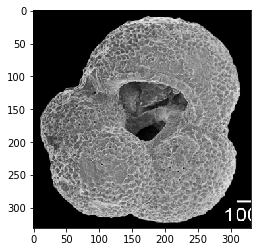

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [38]:
# Randomly select a training image and check the correctness of the genus class

ir = np.random.randint(0, train_labels.shape[0])

print(train_labels[ir])
cl = categorical_to_cls(train_labels[ir])
print(cl)
print(class_names[cl])
try:
    print(family_by_genus_cls[class_names[cl]])
except:
    print(str('family: ' + str(7)))
plt.imshow(train_images[ir])
plt.show()
print(train_lbls[ir])



In [39]:
aug_images_a = np.array(aug_images)
aug_labels_a = np.array(aug_labels)
print(aug_images_a.shape)
print(aug_labels_a.shape)

(1652, 331, 331, 3)
(1652, 20)


In [40]:
idxx = np.arange(len(aug_images_a))
print(idxx)
#np.random.shuffle(idxx)
#print(idxx)

[   0    1    2 ... 1649 1650 1651]


# Use the training images as test images and augmented/transformed images as training data

In [41]:
# Keep the main images as the test images
test_images = train_images
test_labels = train_labels

In [42]:
train_images_interim = train_images
train_labels_interim = train_labels
train_index = np.arange(len(train_images))

In [43]:
train_images_interim = aug_images_a[idxx,]
train_labels_interim = aug_labels_a[idxx,]
train_index = np.arange(len(train_images_interim))
print(train_index)

[   0    1    2 ... 1649 1650 1651]


In [44]:

#print(idxx)

# random shuffle so that in train_valid split classes can be spreaded
#
#print(idxx)

#print(aug_images_a[idxx,])
#print(aug_labels_a[idxx,])



# Use the augmented images as the intermediate images to use them as training and validation images later on

#train_labels_interim = aug_labels_a[idxx,]

#train_index = np.arange(len(train_images_interim))
#print(train_index)

# Check the shape of the training images

In [45]:
print(train_images_interim.shape)
print(train_labels_interim.shape)

print(test_images.shape)
print(test_labels.shape)

(1652, 331, 331, 3)
(1652, 20)
(236, 331, 331, 3)
(236, 20)


# Split the training image into training and validation set for neural net training

In [46]:
whos

Variable                      Type                          Data/Info
---------------------------------------------------------------------
Image                         module                        <module 'PIL.Image' from <...>e-packages/PIL/Image.py'>
ImageDataGenerator            type                          <class 'keras.preprocessi<...>mage.ImageDataGenerator'>
a                             list                          n=1
angle                         int                           285
array_to_img                  function                      <function array_to_img at 0x2b1943b22400>
aug_images                    list                          n=1652
aug_images_a                  ndarray                       1652x331x331x3: 542984316 elems, type `float64`, 4343874528 bytes (4142.641571044922 Mb)
aug_labels                    ndarray                       1652x20: 33040 elems, type `float32`, 132160 bytes (129.0625 kb)
aug_labels_a                  ndarray                    

In [47]:
print(len(train_index))

1652


In [48]:
from sklearn.model_selection import train_test_split

# stratify based on the label so that training and validation data has equal proportion for each class
validation_split = 0.25
train_ids, validation_ids, train_images, validation_images, train_labels, validation_labels = train_test_split(
    train_index,
    train_images_interim,
    train_labels_interim,
    test_size=validation_split,
    shuffle = True, # not needed, by default true
    #stratify=train_labels_interim, 
    random_state=2347) # keep the same random state so that we can compare different models

In [49]:
print(train_images.shape)
print(validation_images.shape)
print(train_labels.shape)
print(validation_labels.shape)

(1239, 331, 331, 3)
(413, 331, 331, 3)
(1239, 20)
(413, 20)


# Check the training and validation images

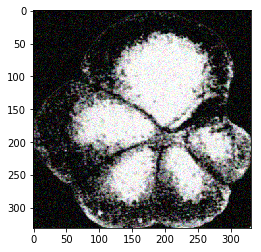

19
Pseudotextularia


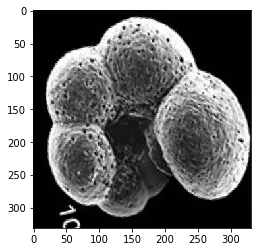

19
Pseudotextularia


In [50]:
train_img_random = np.random.randint(0,train_images.shape[0])

plt.imshow(train_images[train_img_random])
plt.show()
#print(train_labels[train_img_random])
cl = categorical_to_cls(train_labels[train_img_random])
print(cl)
print(class_names[cl])

validation_img_random = np.random.randint(0, validation_images.shape[0])

plt.imshow(validation_images[validation_img_random])
plt.show()
#print(validation_labels[validation_img_random])
cl = categorical_to_cls(validation_labels[validation_img_random])
print(cl)
print(class_names[cl])

# Ensure class distribution in training and validation set for better training

1239

413

[ 49   0   0   0  16   0   0   0 150   0   0   0   0   0   0   0   2   0
   0   0   0  28   0   0   0  93   0   0   0  18   0   0   0  45   0   0
   0   4   0   0   0   0  22   0   0   0  39   0   0   0   4   0   0   0
  11   0   0   0   7   0   0   0   0  10   0   0   0  21   0   0   0   9
   0   0   0  40   0   0   0 671]

[ 21   0   0   0   5   0   0   0  39   0   0   0   0   0   0   0   5   0
   0   0   0   7   0   0   0  40   0   0   0  10   0   0   0  18   0   0
   0   3   0   0   0   0   6   0   0   0  10   0   0   0   3   0   0   0
   3   0   0   0   0   0   0   0   0   4   0   0   0   7   0   0   0   5
   0   0   0   9   0   0   0 218]



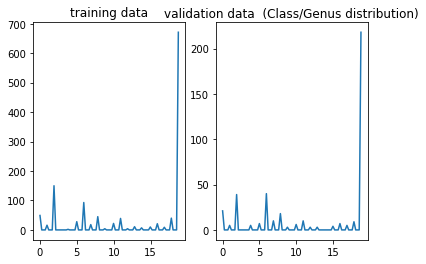

In [51]:
# Check how good is the stratification (class distribution in training and validation data)

tl = []
tlc = []
for x in train_labels:
    cl = categorical_to_cls(x)
    tlc.append(cl)
    
vl = []
vlc = []
for x in validation_labels:
    cl = categorical_to_cls(x)
    vlc.append(cl)    
    
print(len(tlc))
#print(tlc)
print("")
print(len(vlc))
#print(vlc)
print("")

bin_num = 80
th, tbin = np.histogram(tlc, bins=bin_num)
print(th)
print("")
vh, vbin = np.histogram(vlc, bins=bin_num)
print(vh)
print("")

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(tbin[0:bin_num], th)
plt.title('training data')
plt.subplot(1, 2, 2)
plt.plot(vbin[0:bin_num], vh)
plt.title('validation data  (Class/Genus distribution)')
plt.show()
    

# Check the shape of the data

In [52]:
print(train_images.shape)
print(validation_images.shape)
print(test_images.shape)

print(train_labels.shape)
print(validation_labels.shape)
print(test_labels.shape)

(1239, 331, 331, 3)
(413, 331, 331, 3)
(236, 331, 331, 3)
(1239, 20)
(413, 20)
(236, 20)


# Check with just a simple CNN model to see whether deep learning working on the platform

In [53]:
from keras import layers
from keras import models
from time import strftime, gmtime

cur_time = strftime("%Y-%m-%d %H:%M:%S", gmtime())
model_name='simple_convnet' + str(cur_time)

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), use_bias = False, activation='relu', input_shape=(img_width, img_height, img_chan)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), use_bias = False, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), use_bias = False, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Flatten(input_shape = (img_width, img_height, img_chan)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
# model.add(layers.Flatten())
model.add(layers.Dense(len(uniq_cls), activation='sigmoid'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 329, 329, 32)      864       
_________________________________________________________________
batch_normalization_1 (Batch (None, 329, 329, 32)      128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 329, 329, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 164, 164, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 162, 162, 64)      18432     
_________________________________________________________________
batch_normalization_2 (Batch (None, 162, 162, 64)      256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 162, 162, 64)      0         
__________

# Give a model name to distinguish between training models

In [54]:
#classify_by = 'by_family'
#classify_by = 'genus'
classify_by = 'morphogroup'
#classify_by = 'ecogroup'

In [55]:
cur_time = strftime("%Y-%m-%d %H:%M:%S", gmtime())
model_name='vgg19_' + classify_by + '_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_' + str(cur_time)
#model_name = 'convbase_vgg19_adam_epoch_200_two_fc_4096' + str(cur_time)
print(model_name)

vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26


# Load of pretrained models

In [56]:
cur_time = strftime("%Y-%m-%d %H:%M:%S", gmtime())

# Use pretrained modela
# Model 1

#from keras.applications import VGG16
#conv_base_vgg16 = VGG16(weights='imagenet',
#                  include_top=False,
#                  input_shape=(img_width, img_height, img_chan))

# Model 2

from keras.applications import VGG19
conv_base_vgg19 = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(img_width, img_height, img_chan))

# Model 3

from keras.applications import ResNet50

#conv_base_resnet50 = ResNet50(weights='imagenet',
#                  include_top=False,
#                  input_shape=(img_width, img_height, img_chan))

# Model 4
#from keras.applications import InceptionV3

#conv_base_inceptionv3 = InceptionV3(weights='imagenet',
#                  include_top=False, 
#                  input_shape=(img_width, img_height, img_chan))

# Model 5
from keras.applications import InceptionResNetV2

#conv_base_inceptionresnetv2 = InceptionResNetV2(weights = 'imagenet',
#                                               include_top=False, 
#                                               input_shape=(img_width, img_height, img_chan))

# Model 6
#from keras.applications import NASNetLarge

#conv_base_nasnet = NASNetLarge(weights = 'imagenet', 
#                                   include_top = False,
#                                 input_shape=(img_width, img_height, img_chan))

conv_base = conv_base_vgg19
#conv_base = conv_base_inceptionresnetv2
conv_base.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 331, 331, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 331, 331, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 331, 331, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 165, 165, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 165, 165, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 165, 165, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 82, 82, 128)       0         
__________

# Extend a pretrained model

In [57]:
from keras import regularizers

model = models.Sequential()
conv_base.trainable = False
model.add(conv_base)
model.add(layers.Flatten(name='flatten'))
model.add(layers.Dense(4096, activation='relu', name='fc1'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu', name='fc2'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(uniq_cls), activation='sigmoid', kernel_regularizer=regularizers.l2()))

#model.add(layers.Flatten())
#model.add(layers.Dense(512, activation='relu')) #activity_regularizer=regularizers.l1(0.01)
#model.add(layers.BatchNormalization())
#model.add(layers.Dropout(0.5))
#model.add(layers.Dense(len(uniq_cls), activation='sigmoid', kernel_regularizer=regularizers.l2(0.05)))
model_backup = model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 10, 10, 512)       20024384  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              209719296 
_________________________________________________________________
batch_normalization_5 (Batch (None, 4096)              16384     
_________________________________________________________________
dropout_5 (Dropout)          (None, 4096)              0         
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
batch_normalization_6 (Batch (None, 4096)              16384     
__________

# VGG 19 convolution 

In [58]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.utils import get_file
from keras import backend as K
import h5py

def VGG19_convolutions(input_shape = (331, 331, 3),
                       pooling=None,
                       classes=1000):

    model = Sequential()
    
    # Block 1
    model.add(Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1', 
                      input_shape=input_shape))
   
    model.add(Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2'))
    
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))
    
    # Block 2
    model.add(Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1'))
    model.add(Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

    # Block 3
    model.add(Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1'))
    model.add(Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2'))
    model.add(Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3'))
    model.add(Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv4'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

    # Block 4
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1'))
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2'))
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3'))
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv4'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

    # Block 5
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv1'))
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv2'))
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv3'))
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv4'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))

    if pooling == 'avg':
        model.add(GlobalAveragePooling2D())
    elif pooling == 'max':
        model.add(GlobalMaxPooling2D())
    
    return model

In [59]:
VGG19_WEIGHTS_PATH_NO_TOP = ('https://github.com/fchollet/deep-learning-models/'
                             'releases/download/v0.1/'
                             'vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [60]:
weights_path = get_file(
                    'vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    VGG19_WEIGHTS_PATH_NO_TOP,
                    cache_subdir='models',
                    file_hash='6d6bbae143d832006294945121d1f1fc')

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 6d6bbae143d832006294945121d1f1fc so we will re-download the data.
80142336/80134624 [==============================] - 1s 0us/step


# VGG 19 CNN model, blocks sequentially added such that the feature/filter analysis can be done for any layers

In [61]:
set(train_ecogroup_lbls_orig)

{1, 2, 3, 4, 5, 6}

In [62]:
# classify by genus
#total_class_val = len(uniq_cls)

#classify by family
#total_class_val = len(unique_family_cls) + 1
#total_class_val

#classify by ecogroup
total_class_val = len(unique_ecogroup_cls) + 1
total_class_val

# classify by morphogroup
total_class_val = len(unique_morphogroup_cls) + 1
total_class_val

20

In [63]:
model = VGG19_convolutions()

model.load_weights(weights_path)
       
model.add(Flatten(name='flatten'))
model.add(Dense(4096, activation='relu', name='fc1'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu', name='fc2'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(total_class_val, activation='sigmoid', kernel_regularizer=regularizers.l2()))

In [64]:
#model = model_backup
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 331, 331, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 331, 331, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 165, 165, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 165, 165, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 165, 165, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 82, 82, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 82, 82, 256)       295168    
__________

In [65]:
models_dir='/scratch/gilbreth/azehady/automatic_fossil_image_detection/models'

save_period=1
schedule = None

# Callbacks for models, saving of best and last model and tensorboard

In [66]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard
from time import strftime, gmtime

cur_time = strftime("%Y-%m-%d %H:%M:%S", gmtime()) 
best_model_file = '{}/best_{}_{}.h5'.format(models_dir, model_name,cur_time)
print(best_model_file)

class ModelCheckpointMGPU(ModelCheckpoint):
    def __init__(self, original_model, filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1):
        self.original_model = original_model
        super().__init__(filepath, monitor, verbose, save_best_only, save_weights_only, mode, period)

    def on_epoch_end(self, epoch, logs=None):
        self.model = self.original_model
        super().on_epoch_end(epoch, logs)

def freeze_model(model, freeze_before_layer):
    if freeze_before_layer == "ALL":
        for l in model.layers:
            l.trainable = False
    else:
        freeze_before_layer_index = -1
        for i, l in enumerate(model.layers):
            if l.name == freeze_before_layer:
                freeze_before_layer_index = i
        for l in model.layers[:freeze_before_layer_index + 1]:
            l.trainable = False


best_model = ModelCheckpointMGPU(model, filepath=best_model_file, monitor='val_loss',
                                     verbose=1,
                                     mode='min',
                                     period=save_period,
                                     save_best_only=True,
                                     save_weights_only=True)
last_model_file = '{}/last_{}_{}.h5'.format(models_dir, model_name,cur_time)
print(last_model_file)

last_model = ModelCheckpointMGPU(model, filepath=last_model_file, monitor='val_loss',
                                     verbose=1,
                                     mode='min',
                                     period=save_period,
                                     save_best_only=False,
                                     save_weights_only=True)

callbacks = []
callbacks.append(best_model)
callbacks.append(last_model)

tb = TensorBoard("./logs/{}".format(model_name))
callbacks.append(tb)

/scratch/gilbreth/azehady/automatic_fossil_image_detection/models/best_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
/scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5


# Selection of optimizers for CNN

In [67]:
from keras.optimizers import Adam, RMSprop,SGD

opt_pref = 'adam2'
learning_rate = 0.01
momentum=0.9
decay = 0

if opt_pref == 'adam':
    optimizer = 'adam'
elif opt_pref == 'adam2':
    #optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay, amsgrad=False)
    optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-10, decay=decay, amsgrad=False)
elif opt_pref == 'amsgrad':
    optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay, amsgrad=True)
elif opt_pref == 'rmsprop':
    optimizer = RMSprop(lr=learning_rate, decay = decay)
elif opt_pref == 'adamax':
    optimizer = AdaMax(lr=learning_rate, decay = decay)
elif opt_pref == 'sgd':
    optimizer = SGD(lr=learning_rate, decay=decay, momentum=momentum) #, nesterov=True)

In [68]:
epoch = 500
batch_size = 5

In [69]:
genus_batch_size = 20
family_batch_size = 10
ecogroup_batch_size = 5
morphogroup_batch_size = 5

# Learning rate scheduling 

In [70]:
def schedule_steps(epoch, steps):
    for step in steps:
        if step[1] > epoch:
            print("Setting learning rate to {}".format(step[0]))
            return step[0]
        print("Setting learning rate to {}".format(steps[-1][0]))
        return steps[-1][0]

In [71]:
steps = [(1e-6, 2), (1e-5, 10), (5e-6, 20), (3e-6, 25)]
schedule_steps(epoch,steps)

Setting learning rate to 3e-06


3e-06

In [72]:
if steps is not None:
    lrSchedule = LearningRateScheduler(lambda epoch: schedule_steps(epoch, steps))
    callbacks.insert(0, lrSchedule)

# callbacks.append(lrSchedule)

In [73]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=10, min_lr=0.0000001)
callbacks.append(reduce_lr)

In [74]:
callbacks

# Model compilation before training

In [75]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model fitting or training

In [76]:
history = model.fit(train_images, train_labels, validation_data=(validation_images, validation_labels), epochs=epoch, batch_size=batch_size, callbacks=callbacks, verbose=1)
#history = model.fit(train_images, train_labels, validation_split=0.30, epochs=epoch, batch_size=batch_size, callbacks=callbacks, verbose=1)b

Train on 1239 samples, validate on 413 samples
Epoch 1/500
Setting learning rate to 1e-06
1239/1239 [==============================] - 85s 69ms/step - loss: 3.7119 - acc: 0.0581 - val_loss: 3.5248 - val_acc: 0.0169

Epoch 00001: val_loss improved from inf to 3.52480, saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/best_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5

Epoch 00001: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 2/500
Setting learning rate to 1e-06
1239/1239 [==============================] - 78s 63ms/step - loss: 3.6965 - acc: 0.0565 - val_loss: 3.5137 - val_acc: 0.0218

Epoch 00002: val_loss improved from 3.52480 to 3.51367, saving model to

Epoch 13/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 79s 63ms/step - loss: 3.2788 - acc: 0.1614 - val_loss: 3.0771 - val_acc: 0.3971

Epoch 00013: val_loss improved from 3.09232 to 3.07711, saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/best_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5

Epoch 00013: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 14/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 79s 64ms/step - loss: 3.2378 - acc: 0.1630 - val_loss: 2.9728 - val_acc: 0.3874

Epoch 00014: val_loss improved from 3.07711 to 2.97277, saving model to /scratch/gilbreth/azehady/automatic_foss

Epoch 26/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 77s 62ms/step - loss: 2.7831 - acc: 0.3067 - val_loss: 2.5427 - val_acc: 0.4213

Epoch 00026: val_loss did not improve from 2.51025

Epoch 00026: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 27/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 77s 62ms/step - loss: 2.7921 - acc: 0.3261 - val_loss: 2.4864 - val_acc: 0.4140

Epoch 00027: val_loss improved from 2.51025 to 2.48642, saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/best_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5

Epoch 00027: saving model to /scratch/gilbreth/azehady/autom

Epoch 40/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 77s 62ms/step - loss: 2.5977 - acc: 0.3543 - val_loss: 2.3322 - val_acc: 0.4383

Epoch 00040: val_loss improved from 2.33517 to 2.33225, saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/best_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5

Epoch 00040: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 41/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 76s 61ms/step - loss: 2.5136 - acc: 0.3705 - val_loss: 2.3039 - val_acc: 0.4310

Epoch 00041: val_loss improved from 2.33225 to 2.30393, saving model to /scratch/gilbreth/azehady/automatic_foss

Epoch 54/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 77s 62ms/step - loss: 2.2880 - acc: 0.4544 - val_loss: 2.2259 - val_acc: 0.4479

Epoch 00054: val_loss did not improve from 2.20437

Epoch 00054: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 55/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 78s 63ms/step - loss: 2.3476 - acc: 0.4423 - val_loss: 2.3522 - val_acc: 0.4358

Epoch 00055: val_loss did not improve from 2.20437

Epoch 00055: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 56/500
Setting learning rate to 3e-06
1239/123


Epoch 00071: val_loss did not improve from 2.20437

Epoch 00071: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 72/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 69s 56ms/step - loss: 2.1724 - acc: 0.4810 - val_loss: 2.2930 - val_acc: 0.4504

Epoch 00072: val_loss did not improve from 2.20437

Epoch 00072: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 73/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 69s 56ms/step - loss: 2.2073 - acc: 0.4722 - val_loss: 2.3906 - val_acc: 0.4407

Epoch 00073: val_loss did not improve from 2.20437


Epoch 106/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 69s 55ms/step - loss: 1.9349 - acc: 0.5416 - val_loss: 2.1916 - val_acc: 0.5012

Epoch 00106: val_loss did not improve from 2.16157

Epoch 00106: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 107/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 69s 55ms/step - loss: 1.9583 - acc: 0.5577 - val_loss: 2.5903 - val_acc: 0.4722

Epoch 00107: val_loss did not improve from 2.16157

Epoch 00107: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 108/500
Setting learning rate to 3e-06
1239/

Epoch 122/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 69s 55ms/step - loss: 1.8361 - acc: 0.5860 - val_loss: 2.1618 - val_acc: 0.4746

Epoch 00122: val_loss did not improve from 2.08265

Epoch 00122: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 123/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 69s 55ms/step - loss: 1.7951 - acc: 0.6166 - val_loss: 2.1986 - val_acc: 0.4722

Epoch 00123: val_loss did not improve from 2.08265

Epoch 00123: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 124/500
Setting learning rate to 3e-06
1239/

Epoch 155/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 69s 55ms/step - loss: 1.7558 - acc: 0.6166 - val_loss: 2.2357 - val_acc: 0.4818

Epoch 00155: val_loss did not improve from 2.02408

Epoch 00155: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 156/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 69s 55ms/step - loss: 1.7152 - acc: 0.6295 - val_loss: 2.2391 - val_acc: 0.4964

Epoch 00156: val_loss did not improve from 2.02408

Epoch 00156: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 157/500
Setting learning rate to 3e-06
1239/


Epoch 00188: val_loss did not improve from 1.94720

Epoch 00188: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 189/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 70s 56ms/step - loss: 1.4880 - acc: 0.6860 - val_loss: 2.0428 - val_acc: 0.5569

Epoch 00189: val_loss did not improve from 1.94720

Epoch 00189: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 190/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 70s 56ms/step - loss: 1.4709 - acc: 0.6998 - val_loss: 2.0500 - val_acc: 0.5642

Epoch 00190: val_loss did not improve from 1.9472

Epoch 206/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 70s 56ms/step - loss: 1.4346 - acc: 0.7038 - val_loss: 1.9960 - val_acc: 0.5787

Epoch 00206: val_loss did not improve from 1.94720

Epoch 00206: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 207/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 70s 56ms/step - loss: 1.4263 - acc: 0.7014 - val_loss: 2.0321 - val_acc: 0.5545

Epoch 00207: val_loss did not improve from 1.94720

Epoch 00207: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 208/500
Setting learning rate to 3e-06
1239/


Epoch 00240: val_loss did not improve from 1.94720

Epoch 00240: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 241/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 70s 57ms/step - loss: 1.3628 - acc: 0.7151 - val_loss: 2.0068 - val_acc: 0.5811

Epoch 00241: val_loss did not improve from 1.94720

Epoch 00241: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 242/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 70s 57ms/step - loss: 1.3546 - acc: 0.7127 - val_loss: 2.0991 - val_acc: 0.5642

Epoch 00242: val_loss did not improve from 1.9472

Epoch 258/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 75s 60ms/step - loss: 1.3330 - acc: 0.7191 - val_loss: 2.0228 - val_acc: 0.5666

Epoch 00258: val_loss did not improve from 1.94720

Epoch 00258: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 259/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 75s 60ms/step - loss: 1.3701 - acc: 0.7159 - val_loss: 2.1219 - val_acc: 0.5714

Epoch 00259: val_loss did not improve from 1.94720

Epoch 00259: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 260/500
Setting learning rate to 3e-06
1239/


Epoch 00292: val_loss did not improve from 1.94720

Epoch 00292: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 293/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 70s 56ms/step - loss: 1.3245 - acc: 0.7175 - val_loss: 2.2415 - val_acc: 0.5206

Epoch 00293: val_loss did not improve from 1.94720

Epoch 00293: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 294/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 71s 57ms/step - loss: 1.3599 - acc: 0.7086 - val_loss: 2.2439 - val_acc: 0.5230

Epoch 00294: val_loss did not improve from 1.9472

Epoch 310/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 69s 55ms/step - loss: 1.3800 - acc: 0.6949 - val_loss: 2.2036 - val_acc: 0.5133

Epoch 00310: val_loss did not improve from 1.94720

Epoch 00310: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 311/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 69s 55ms/step - loss: 1.3059 - acc: 0.7215 - val_loss: 2.3352 - val_acc: 0.5157

Epoch 00311: val_loss did not improve from 1.94720

Epoch 00311: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 312/500
Setting learning rate to 3e-06
1239/


Epoch 00344: val_loss did not improve from 1.94720

Epoch 00344: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 345/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 69s 55ms/step - loss: 1.2404 - acc: 0.7377 - val_loss: 2.2964 - val_acc: 0.5254

Epoch 00345: val_loss did not improve from 1.94720

Epoch 00345: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 346/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 69s 55ms/step - loss: 1.2383 - acc: 0.7337 - val_loss: 2.2846 - val_acc: 0.5375

Epoch 00346: val_loss did not improve from 1.9472

Epoch 362/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 69s 55ms/step - loss: 1.2502 - acc: 0.7296 - val_loss: 2.2155 - val_acc: 0.5424

Epoch 00362: val_loss did not improve from 1.94720

Epoch 00362: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 363/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 69s 55ms/step - loss: 1.2625 - acc: 0.7167 - val_loss: 2.1556 - val_acc: 0.5569

Epoch 00363: val_loss did not improve from 1.94720

Epoch 00363: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 364/500
Setting learning rate to 3e-06
1239/


Epoch 00396: val_loss did not improve from 1.94720

Epoch 00396: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 397/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 69s 55ms/step - loss: 1.2453 - acc: 0.7328 - val_loss: 2.3955 - val_acc: 0.5230

Epoch 00397: val_loss did not improve from 1.94720

Epoch 00397: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 398/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 69s 55ms/step - loss: 1.2082 - acc: 0.7377 - val_loss: 2.2878 - val_acc: 0.5109

Epoch 00398: val_loss did not improve from 1.9472

Epoch 414/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 69s 55ms/step - loss: 1.1784 - acc: 0.7441 - val_loss: 2.1535 - val_acc: 0.5690

Epoch 00414: val_loss did not improve from 1.94720

Epoch 00414: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 415/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 69s 55ms/step - loss: 1.1986 - acc: 0.7417 - val_loss: 2.3217 - val_acc: 0.5472

Epoch 00415: val_loss did not improve from 1.94720

Epoch 00415: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 416/500
Setting learning rate to 3e-06
1239/


Epoch 00448: val_loss did not improve from 1.94720

Epoch 00448: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 449/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 69s 55ms/step - loss: 1.2056 - acc: 0.7312 - val_loss: 2.1421 - val_acc: 0.5375

Epoch 00449: val_loss did not improve from 1.94720

Epoch 00449: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 450/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 69s 55ms/step - loss: 1.1855 - acc: 0.7433 - val_loss: 2.3356 - val_acc: 0.5206

Epoch 00450: val_loss did not improve from 1.9472

Epoch 466/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 69s 55ms/step - loss: 1.1237 - acc: 0.7554 - val_loss: 2.1243 - val_acc: 0.5763

Epoch 00466: val_loss did not improve from 1.94720

Epoch 00466: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 467/500
Setting learning rate to 3e-06
1239/1239 [==============================] - 69s 55ms/step - loss: 1.1045 - acc: 0.7611 - val_loss: 2.2465 - val_acc: 0.5400

Epoch 00467: val_loss did not improve from 1.94720

Epoch 00467: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5
Epoch 468/500
Setting learning rate to 3e-06
1239/


Epoch 00500: val_loss did not improve from 1.94720

Epoch 00500: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5


In [239]:
# """
# Plotting multiple scalars on the same graph
# """
# from numpy import random
    
# writer_val = tf.summary.FileWriter("./logs/{}/plot_val".format(model_name))
# writer_train = tf.summary.FileWriter("./logs/{}/plot_train".format(model_name))
# loss_var = tf.Variable(0.0)
# tf.summary.scalar("loss", loss_var)
# write_op = tf.summary.merge_all()
# session = tf.InteractiveSession()
# session.run(tf.global_variables_initializer())
# for i in range(100):
#  # loss validation
#  summary = session.run(write_op, {loss_var: random.rand()})
#  writer_val.add_summary(summary, i)
#  writer_val.flush()
#  # loss train
#  summary = session.run(write_op, {loss_var: random.rand()})
#  writer_train.add_summary(summary, i)
#  writer_train.flush()

# Loading of best and last model after analyzing in tensorboard or simple evaluation

models_dir = '/scratch/gilbreth/azehady/projects/automatic_fossil_image_detection/'

In [77]:
#best_model_file = './models/' + 'best_vgg19_extended_adam_epoch_200_two_fc_40962019-03-21 22:03:02_2019-03-21 22:04:46.h5'
#last_model_file = './models/' + 'last_vgg19_extended_adam_epoch_200_two_fc_40962019-03-21 22:03:02_2019-03-21 22:04:46.h5'

#best_model_file = './models/' + 'best_vgg19_extended_adam_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2019-03-28 13:14:53_2019-03-28 13:15:37.h5'
#last_model_file = './models/' + 'last_vgg19_extended_adam_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2019-03-28 13:14:53_2019-03-28 13:15:37.h5'

#best_model_file = './models/best_vgg19_extended_adam_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2019-03-28 13:14:53_2019-03-28 13:15:37.h5'
#last_model_file = './models/last_vgg19_extended_adam_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2019-03-28 13:14:53_2019-03-28 13:15:37.h5'

#best_model_file = './models/best_vgg19_extended_adam_epoch_200_two_fc_4096_lr_0.01_time_2019-03-27 23:54:18_2019-03-27 23:54:44.h5'
#last_model_file = './models/last_vgg19_extended_adam_epoch_200_two_fc_4096_lr_0.01_time_2019-03-27 23:54:18_2019-03-27 23:54:44.h5'

#best_model_file = models_dir + './models/best_vgg19_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-01 23:45:31_2020-02-01 23:46:01.h5'
#last_model_file = models_dir + './models/last_vgg19_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-01 23:45:31_2020-02-01 23:46:01.h5'

#best_model_file = '/scratch/gilbreth/azehady/automatic_fossil_image_detection/models/best_vgg19_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-03 17:51:43_2020-02-03 17:52:45.h5'
#last_model_file = models_dir + './models/last_vgg19_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-01 23:45:31_2020-02-01 23:46:01.h5'

#best_model_file = '/scratch/gilbreth/azehady/automatic_fossil_image_detection/models/best_vgg19_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-05 04:31:54_2020-02-05 04:31:59.h5'

#best_model_file2 = '/scratch/gilbreth/azehady/automatic_fossil_image_detection/models/best_vgg19_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-05 04:31:54_2020-02-05 04:31:59.h5'

#best_model_file = '/scratch/gilbreth/azehady/automatic_fossil_image_detection/models/best_vgg19_by_family_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-09 03:17:54_2020-02-09 03:17:58.h5'

#best_model_file = '/scratch/gilbreth/azehady/automatic_fossil_image_detection/models/best_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-13 22:48:54_2020-02-13 22:49:55.h5'

#best_model_file = '/scratch/gilbreth/azehady/automatic_fossil_image_detection/models/best_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-14 03:33:25_2020-02-14 03:33:30.h5'

#last_model_file = '/scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-17 21:10:14_2020-02-17 21:10:18.h5'
#best_model_file = '/scratch/gilbreth/azehady/automatic_fossil_image_detection/models/best_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-17 21:10:14_2020-02-17 21:10:18.h5'

#best_model_file = '/scratch/gilbreth/azehady/automatic_fossil_image_detection/models/best_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-17 17:48:40_2020-02-17 17:52:31.h5'

best_model_file = '/scratch/gilbreth/azehady/automatic_fossil_image_detection/models/best_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5'
last_model_file = '/scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5'

In [78]:
# load the best model and continue training

model.load_weights(best_model_file)

In [93]:
epoch = 350
batch_size = 5

history = model.fit(train_images, train_labels, validation_data=(validation_images, validation_labels), epochs=epoch, batch_size=batch_size, callbacks=callbacks, verbose=1)

Train on 1239 samples, validate on 413 samples
Epoch 1/350
Setting learning rate to 1e-06
1239/1239 [==============================] - 60s 48ms/step - loss: 1.6172 - acc: 0.5787 - val_loss: 1.6191 - val_acc: 0.5666

Epoch 00001: val_loss improved from inf to 1.61907, saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/best_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5

Epoch 00001: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 2/350
Setting learning rate to 1e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 1.4491 - acc: 0.5900 - val_loss: 1.5755 - val_acc: 0.5666

Epoch 00002: val_loss improved from 1.61907 to 1.57549, saving model to /scra

Epoch 30/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.8200 - acc: 0.7232 - val_loss: 1.2417 - val_acc: 0.5908

Epoch 00030: val_loss improved from 1.24566 to 1.24167, saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/best_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5

Epoch 00030: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 31/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.7933 - acc: 0.7393 - val_loss: 1.3481 - val_acc: 0.5666

Epoch 00031: val_loss did not improve from 1.24167

Epoch 00031: saving model to /scratch/gilbreth/azehady/automatic_f


Epoch 00045: val_loss did not improve from 1.14945

Epoch 00045: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 46/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.6745 - acc: 0.7692 - val_loss: 1.2681 - val_acc: 0.6150

Epoch 00046: val_loss did not improve from 1.14945

Epoch 00046: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 47/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.6486 - acc: 0.7845 - val_loss: 1.1927 - val_acc: 0.5908

Epoch 00047: val_loss did not improve from 1.14945

Epoch

Epoch 62/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.6231 - acc: 0.7942 - val_loss: 1.1416 - val_acc: 0.6659

Epoch 00062: val_loss did not improve from 1.06207

Epoch 00062: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 63/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.6025 - acc: 0.7998 - val_loss: 1.1915 - val_acc: 0.6610

Epoch 00063: val_loss did not improve from 1.06207

Epoch 00063: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 64/350
Setting learning rate to 3e-06
1239/1239 [===

Epoch 79/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.6384 - acc: 0.7893 - val_loss: 1.2721 - val_acc: 0.5956

Epoch 00079: val_loss did not improve from 1.04809

Epoch 00079: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 80/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.6195 - acc: 0.8087 - val_loss: 1.3306 - val_acc: 0.5690

Epoch 00080: val_loss did not improve from 1.04809

Epoch 00080: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 81/350
Setting learning rate to 3e-06
1239/1239 [===

Epoch 97/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.5471 - acc: 0.8313 - val_loss: 1.1956 - val_acc: 0.6320

Epoch 00097: val_loss did not improve from 1.04809

Epoch 00097: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 98/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.5429 - acc: 0.8249 - val_loss: 1.1332 - val_acc: 0.6731

Epoch 00098: val_loss did not improve from 1.04809

Epoch 00098: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 99/350
Setting learning rate to 3e-06
1239/1239 [===

Epoch 114/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.5438 - acc: 0.8329 - val_loss: 1.3511 - val_acc: 0.5884

Epoch 00114: val_loss did not improve from 1.01484

Epoch 00114: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 115/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.5377 - acc: 0.8305 - val_loss: 1.3681 - val_acc: 0.5884

Epoch 00115: val_loss did not improve from 1.01484

Epoch 00115: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 116/350
Setting learning rate to 3e-06
1239/1239 [


Epoch 00131: val_loss did not improve from 1.01484

Epoch 00131: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 132/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.5159 - acc: 0.8297 - val_loss: 1.3668 - val_acc: 0.6320

Epoch 00132: val_loss did not improve from 1.01484

Epoch 00132: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 133/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.5156 - acc: 0.8378 - val_loss: 1.1216 - val_acc: 0.6634

Epoch 00133: val_loss did not improve from 1.01484

Epo

Epoch 149/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.5138 - acc: 0.8354 - val_loss: 1.0653 - val_acc: 0.6707

Epoch 00149: val_loss did not improve from 1.01484

Epoch 00149: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 150/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.4749 - acc: 0.8515 - val_loss: 1.2000 - val_acc: 0.6489

Epoch 00150: val_loss did not improve from 1.01484

Epoch 00150: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 151/350
Setting learning rate to 3e-06
1239/1239 [


Epoch 00166: val_loss did not improve from 1.01484

Epoch 00166: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 167/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.5382 - acc: 0.8362 - val_loss: 1.0437 - val_acc: 0.6489

Epoch 00167: val_loss did not improve from 1.01484

Epoch 00167: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 168/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.5133 - acc: 0.8305 - val_loss: 1.0669 - val_acc: 0.6828

Epoch 00168: val_loss did not improve from 1.01484

Epo

Epoch 182/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.5054 - acc: 0.8345 - val_loss: 1.1579 - val_acc: 0.6828

Epoch 00182: val_loss did not improve from 0.94625

Epoch 00182: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 183/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.5106 - acc: 0.8362 - val_loss: 1.1838 - val_acc: 0.6925

Epoch 00183: val_loss did not improve from 0.94625

Epoch 00183: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 184/350
Setting learning rate to 3e-06
1239/1239 [


Epoch 00199: val_loss did not improve from 0.94625

Epoch 00199: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 200/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.5080 - acc: 0.8345 - val_loss: 1.1626 - val_acc: 0.6901

Epoch 00200: val_loss did not improve from 0.94625

Epoch 00200: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 201/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.5150 - acc: 0.8329 - val_loss: 1.1624 - val_acc: 0.6852

Epoch 00201: val_loss did not improve from 0.94625

Epo

Epoch 217/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.4813 - acc: 0.8450 - val_loss: 1.0744 - val_acc: 0.6828

Epoch 00217: val_loss did not improve from 0.94625

Epoch 00217: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 218/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.4686 - acc: 0.8515 - val_loss: 1.0419 - val_acc: 0.6828

Epoch 00218: val_loss did not improve from 0.94625

Epoch 00218: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 219/350
Setting learning rate to 3e-06
1239/1239 [


Epoch 00234: val_loss did not improve from 0.94625

Epoch 00234: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 235/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.4750 - acc: 0.8491 - val_loss: 0.9092 - val_acc: 0.7264

Epoch 00235: val_loss improved from 0.94625 to 0.90924, saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/best_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5

Epoch 00235: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-

Epoch 269/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.4792 - acc: 0.8547 - val_loss: 1.0137 - val_acc: 0.6998

Epoch 00269: val_loss did not improve from 0.90924

Epoch 00269: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 270/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.4808 - acc: 0.8426 - val_loss: 0.9831 - val_acc: 0.7143

Epoch 00270: val_loss did not improve from 0.90924

Epoch 00270: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 271/350
Setting learning rate to 3e-06
1239/1239 [


Epoch 00286: val_loss did not improve from 0.90924

Epoch 00286: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 287/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.4421 - acc: 0.8555 - val_loss: 0.9131 - val_acc: 0.7385

Epoch 00287: val_loss did not improve from 0.90924

Epoch 00287: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 288/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.4680 - acc: 0.8523 - val_loss: 1.0595 - val_acc: 0.6901

Epoch 00288: val_loss did not improve from 0.90924

Epo

Epoch 304/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.4305 - acc: 0.8684 - val_loss: 1.0320 - val_acc: 0.7046

Epoch 00304: val_loss did not improve from 0.90924

Epoch 00304: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 305/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.4475 - acc: 0.8579 - val_loss: 1.1410 - val_acc: 0.6634

Epoch 00305: val_loss did not improve from 0.90924

Epoch 00305: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 306/350
Setting learning rate to 3e-06
1239/1239 [

Epoch 321/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.4619 - acc: 0.8620 - val_loss: 0.9044 - val_acc: 0.7482

Epoch 00321: val_loss improved from 0.90706 to 0.90437, saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/best_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5

Epoch 00321: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 322/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.4350 - acc: 0.8636 - val_loss: 0.9747 - val_acc: 0.7215

Epoch 00322: val_loss did not improve from 0.90437

Epoch 00322: saving model to /scratch/gilbreth/azehady/automatic


Epoch 00337: val_loss did not improve from 0.87640

Epoch 00337: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 338/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.4960 - acc: 0.8410 - val_loss: 1.1780 - val_acc: 0.6610

Epoch 00338: val_loss did not improve from 0.87640

Epoch 00338: saving model to /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5
Epoch 339/350
Setting learning rate to 3e-06
1239/1239 [==============================] - 56s 45ms/step - loss: 0.4430 - acc: 0.8612 - val_loss: 1.0241 - val_acc: 0.7070

Epoch 00339: val_loss did not improve from 0.87640

Epo

In [ ]:
models_dir = '/scratch/gilbreth/azehady/automatic_fossil_image_detection/models/'

In [73]:
best_model_file = models_dir + 'best_vgg19_by_family_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-09 14:04:13_2020-02-09 14:04:18.h5'
last_model_file = models_dir + 'last_vgg19_by_family_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-09 14:04:13_2020-02-09 14:04:18.h5'

In [94]:
models_dir = '/scratch/gilbreth/azehady/automatic_fossil_image_detection/models/'
best_model_file = models_dir + 'best_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5'
last_model_file = models_dir + 'last_vgg19_ecogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 04:08:36_2020-02-18 04:08:47.h5'

In [80]:
import pickle

train_history_file_name = best_model_file + '.history' 
print("Saving the history in file: " + str(train_history_file_name))
with open(train_history_file_name, 'wb') as f:
    pickle.dump(history.history, f)

Saving the history in file: /scratch/gilbreth/azehady/automatic_fossil_image_detection/models/best_vgg19_morphogroup_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2020-02-18 16:39:26_2020-02-18 16:39:33.h5.history


In [83]:
with open(train_history_file_name, 'rb') as f:
    history = pickle.load(f)

In [84]:
history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])

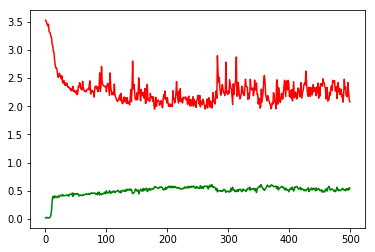

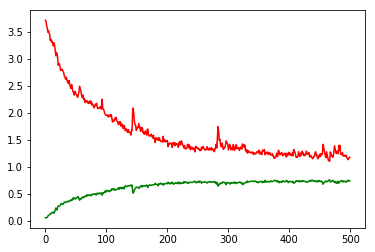

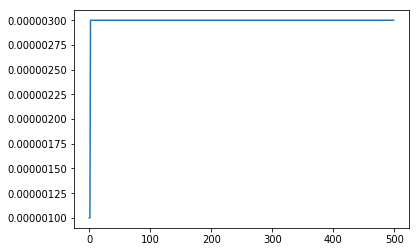

In [85]:
from matplotlib import pyplot as plt

plt.plot(history['val_loss'], color='red')
plt.plot(history['val_acc'], color='green')
plt.show()

plt.plot(history['loss'], color='red')
plt.plot(history['acc'], color='green')
plt.show()

plt.plot(history['lr'])
plt.show()

In [92]:
# last model
# last_convbase_vgg19_img_dim_331_kernel_regularizer2018-10-28 02:20:00_2018-10-28 03:53:16.h5
model.load_weights(last_model_file)

In [90]:
res_last = model.evaluate(test_images, test_labels)
print(res_last)

# best model
# ./models/

236/236 [==============================] - 2s 8ms/step
[0.6258001873048685, 0.8855932193287348]


In [91]:
#best_convbase_vgg19_img_dim_331_kernel_regularizer2018-10-28 02:20:00_2018-10-28 03:53:16.h5

model.load_weights(best_model_file)

In [93]:
res_best = model.evaluate(test_images, test_labels)
print(res_best)

236/236 [==============================] - 2s 8ms/step
[0.6258001873048685, 0.8855932193287348]


In [95]:
model.evaluate(train_images, train_labels)

1239/1239 [==============================] - 14s 12ms/step


[0.8711601795449768, 0.8571428568061077]

In [94]:
model.evaluate(validation_images, validation_labels)

413/413 [==============================] - 5s 11ms/step


[2.0789365347014788, 0.5496368024308803]

In [ ]:
pred = model.predict(test_images, verbose=1)

In [ ]:
n = pred.shape[1]
print(n)
pred_cls_identity = np.eye(n)
idx = np.argmax(pred, axis=1)

# creating the predicted class from identity matrix
pred_cls = pred_cls_identity[idx]
print(pred_cls.shape)

# Analysis of errors

In [ ]:
#Show the true and predicted class distribution

true_clss = [categorical_to_cls(tc) for tc in test_labels]
plt.hist(true_clss, bins=78)
plt.show()

pred_clss = [categorical_to_cls(pc) for pc in pred_cls]
plt.hist(pred_clss, bins = 78)
plt.show()

In [ ]:
# calculating accuracy

total_n = test_labels.shape[0]
print(total_n)
pred_acc_t = [np.sum(test_labels[i] == pred_cls[i]) == n for i in np.arange(total_n)]
pred_acc_ix = [i for i in np.arange(total_n) if np.sum(test_labels[i] == pred_cls[i]) == n]
pred_err_t = [np.sum(test_labels[i] == pred_cls[i]) != n for i in np.arange(total_n)]
pred_err_ix = [i for i in np.arange(total_n) if np.sum(test_labels[i] == pred_cls[i]) != n]
pred_acc = np.sum(pred_acc_t)/total_n
pred_err = np.sum(pred_err_t)/total_n
print(pred_acc)
print(pred_err)

# Check the correctly predicted images and classes

In [ ]:
acc_cls = []
acc_cls_names = []

print(len(pred_acc_ix))
for i, acc_img_ix in enumerate(pred_acc_ix):
    #true
    
    #print(test_labels[i])
    #print(pred_cls[i])
    cl = categorical_to_cls(test_labels[acc_img_ix])
    acc_cls.append(cl)
    acc_cls_names.append(class_names[cl])
    
    #predicted
    pcl = categorical_to_cls(pred_cls[acc_img_ix]) # genus class for i-th image is predicted as class id "pcl"

    print("true class = " + str(cl))
    print("true class name = " + str(class_names[cl]))
    print("Number of images in original training data for this class = " + str(len(multi_cls[class_names[cl]])))
    print("predicted class = " + str(pcl))
    print("predicted class name = " + str(class_names[pcl]))

    # Show the image
    plt.figure(figsize=(5,5))
    plt.subplot(1,1, 1)
    plt.imshow(test_images[acc_img_ix])
    
    plt.show()
    
    
    # Check the first sample of the predicted class from the train image
    #final_cls: Dict keyed by the unique genus names, values indicate the index of the first image file with the same genus
    #class_names: Dict gives the unique genus/class id for 236 genus files, keyed by the unique genus name
    # show all the images in the test file which has the the predicted class id
    pred_cls_ids = multi_cls[class_names[pcl]]
    print("Accurate image id = " + str(acc_img_ix))
    print("Ids with the same predicted class = ")
    print(pred_cls_ids)
    n_pred_cls_ids = len(pred_cls_ids)
    plt.figure(figsize=(15,15))
    for j in range(n_pred_cls_ids):
        plt.subplot(1,n_pred_cls_ids, j+1)
        idx = pred_cls_ids[j]
        plt.imshow(test_images[idx])
    plt.show()
    
    plt.show()

# Check the errored images and classes

In [ ]:
err_cls = []
err_cls_names = []

print(len(pred_err_ix))
for i, err_img_ix in enumerate(pred_err_ix):
    #true
    
    #print(test_labels[i])
    #print(pred_cls[i])
    cl = categorical_to_cls(test_labels[err_img_ix])
    err_cls.append(cl)
    err_cls_names.append(class_names[cl])
    
    #predicted
    pcl = categorical_to_cls(pred_cls[err_img_ix]) # genus class for i-th image is predicted as class id "pcl"

    print("true class = " + str(cl))
    print("true class name = " + str(class_names[cl]))
    print("Number of images in original training data for this class = " + str(len(multi_cls[class_names[cl]])))
    print("predicted class = " + str(pcl))
    print("predicted class name = " + str(class_names[pcl]))


    # Show the image
    plt.figure(figsize=(5,5))
    plt.subplot(1,1, 1)
    plt.imshow(test_images[err_img_ix])
    
    plt.show()
    
    
    # Check the first sample of the predicted class from the train image
    #final_cls: Dict keyed by the unique genus names, values indicate the index of the first image file with the same genus
    #class_names: Dict gives the unique genus/class id for 236 genus files, keyed by the unique genus name
    # show all the images in the test file which has the the predicted class id
    pred_cls_ids = multi_cls[class_names[pcl]]
    print("Accurate image id = " + str(err_img_ix))
    print("Ids with the incorrectly predicted class = ")
    print(pred_cls_ids)
    n_pred_cls_ids = len(pred_cls_ids)
    plt.figure(figsize=(15,15))
    for j in range(n_pred_cls_ids):
        plt.subplot(1,n_pred_cls_ids, j+1)
        idx = pred_cls_ids[j]
        plt.imshow(test_images[idx])
    plt.show()
    

In [ ]:
# which are the erred classes
err_cls_s = set(err_cls)
np.array(err_cls_s)
print(len(err_cls_s))
print(236-len(err_cls_s))

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Test with unseen species and see whether the genus names are predicted correctly

In [60]:
# load the new test image files (unseen classes)
import copy
path = './datapack_images/Global/Foram_New_Test_Images'

new_test_file_names = None
for (dirpath, dirnames, fnames) in walk(path):
    new_test_file_names = fnames

new_test_image_files = []
new_genus_single = []

for f in new_test_file_names:
    forig = copy.copy(f)
    new_test_image_files.append(forig)

    if ' ' in f:
        f = f.split(' ')
        new_genus_single.append(f[0])
        
for i, f in enumerate(new_test_image_files):
    print(f)
    print(new_genus_single[i])
    
#print(len(genus_single))
#print(genus_multiple)

Globigerina bulloides.png
Globigerina
Morozovella caucasica.png
Morozovella
Globorotalia miozea.png
Globorotalia
Sphaeroidinella dehiscens.png
Sphaeroidinella
Globigerinoides seigliei.png
Globigerinoides
Morozovella apanthesma.png
Morozovella
Globigerinoides altiapertura.png
Globigerinoides
Globigerinoides extremus.png
Globigerinoides
Morozovella aequa.png
Morozovella
Globigerina falcoensis.png
Globigerina
Globigerina archaeobulloides 2.png
Globigerina
Trilobatus scicanus.png
Trilobatus
Globigerina archaeobulloides.png
Globigerina
Acarinina aspensis.png
Acarinina
Morozovella subbotinae.png
Morozovella
Hantkenina australis.png
Hantkenina
Globigerinoides subquadratus.png
Globigerinoides
Globigerinoides obliquus.png
Globigerinoides
Globoconella terminalis.png
Globoconella
Globigerinoides italicus.png
Globigerinoides
Acarinina echinata.png
Acarinina
Globigerina officinalis.png
Globigerina
Morozovella preangulata.png
Morozovella
Acarinina altoconica.png
Acarinina
Globigerinella siphonifera.

# Getting new classes for the new test data 

In [61]:
# Load image data from file
# And augment images
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import to_categorical
import cv2 as cv

img_width = 331 #128 * 2 * 2
img_height = 331 #128 * 2 * 2
img_chan = 3

#plt.figure(figsize=(20,10))
new_test_imgs = []
new_test_lbls = []
for j, fname in enumerate(new_test_image_files):
    img = load_img(path + '/' + fname)
    
    # converting to numpy array
    imga = np.array(img)
    
    # reshaping to same size using the power of cv
    imgr = cv.resize(imga, (img_width, img_height), interpolation=cv.INTER_AREA)
    #print(imgr.shape)
    new_test_imgs.append(imgr)
    print(new_genus_single[j])
    clas = final_cls[new_genus_single[j]]
    new_test_lbls.append(clas)
    
    #plt.subplot((j%10) + 1,len(file_names), (j%10) + 1)
    print(j)
    print(fname)
    print(new_genus_single[j])
    print(clas)
    print("")
    #plt.imshow(train_imgs[j])

    #plt.show()



Globigerina
0
Globigerina bulloides.png
Globigerina
25

Morozovella
1
Morozovella caucasica.png
Morozovella
19

Globorotalia
2
Globorotalia miozea.png
Globorotalia
2

Sphaeroidinella
3
Sphaeroidinella dehiscens.png
Sphaeroidinella
76

Globigerinoides
4
Globigerinoides seigliei.png
Globigerinoides
24

Morozovella
5
Morozovella apanthesma.png
Morozovella
19

Globigerinoides
6
Globigerinoides altiapertura.png
Globigerinoides
24

Globigerinoides
7
Globigerinoides extremus.png
Globigerinoides
24

Morozovella
8
Morozovella aequa.png
Morozovella
19

Globigerina
9
Globigerina falcoensis.png
Globigerina
25

Globigerina
10
Globigerina archaeobulloides 2.png
Globigerina
25

Trilobatus
11
Trilobatus scicanus.png
Trilobatus
64

Globigerina
12
Globigerina archaeobulloides.png
Globigerina
25

Acarinina
13
Acarinina aspensis.png
Acarinina
6

Morozovella
14
Morozovella subbotinae.png
Morozovella
19

Hantkenina
15
Hantkenina australis.png
Hantkenina
66

Globigerinoides
16
Globigerinoides subquadratus.pn

In [ ]:
np.argwhere(train_labels[0])

In [62]:
# get the main training image data
new_test_images = np.array(new_test_imgs)
# For Dense layers
#new_test_images = new_test_images.reshape(len(new_test_images), img_width * img_height * img_chan)
# For CNN
new_test_images = new_test_images.reshape(len(new_test_images), img_width, img_height, img_chan)
new_test_images = new_test_images.astype('float32') / 255

# convert into categorical y label
new_test_labels = np.zeros((len(new_test_lbls),len(uniq_cls)))
for i, li in enumerate(new_test_lbls):
    new_test_labels[i, li] = 1


In [63]:
print(new_test_images.shape)
print(new_test_labels.shape)

(37, 331, 331, 3)
(37, 79)


In [64]:
model.evaluate(new_test_images, new_test_labels)

37/37 [==============================] - 1s 19ms/step


[2.997282898103869, 0.37837838160025106]

# Analyzing errored new images

In [ ]:
new_pred = model.predict(new_test_images, verbose = 1)

In [ ]:
new_n = new_pred.shape[1]
print(n)
new_pred_cls_identity = np.eye(new_n)
idx = np.argmax(new_pred, axis=1)
# creating the predicted class from identity matrix
new_pred_cls = new_pred_cls_identity[idx]
print(new_pred_cls)

In [ ]:
#Show the true and predicted class distribution

new_true_clss = [categorical_to_cls(tc) for tc in new_test_labels]
plt.hist(new_true_clss, bins=78)
plt.show()

new_pred_clss = [categorical_to_cls(pc) for pc in new_pred_cls]
plt.hist(new_pred_clss, bins = 78)
plt.show()

In [ ]:
# calculating accuracy
new_total_n = new_test_labels.shape[0]
new_pred_acc_t = [np.sum(new_test_labels[i] == new_pred_cls[i]) == new_n for i in np.arange(new_total_n)]
new_pred_acc_ix = [i for i in np.arange(new_total_n) if np.sum(new_test_labels[i] == new_pred_cls[i]) == new_n]
new_pred_err_t = [np.sum(new_test_labels[i] == new_pred_cls[i]) != n for i in np.arange(new_total_n)]
new_pred_err_ix = [i for i in np.arange(new_total_n) if np.sum(new_test_labels[i] == new_pred_cls[i]) != new_n]
new_pred_acc = np.sum(new_pred_acc_t)/new_total_n
new_pred_err = np.sum(new_pred_err_t)/new_total_n
print(new_pred_acc)
print(new_pred_err)

# Analyze the correct prediction

In [ ]:
new_acc_cls = []
new_acc_cls_names = []

print(len(new_pred_acc_ix))
for i, new_acc_img_ix in enumerate(new_pred_acc_ix):
    #true
    
    print(i)
    cl = categorical_to_cls(new_test_labels[new_acc_img_ix])
    new_acc_cls.append(cl)
    new_acc_cls_names.append(class_names[cl])
    
    #predicted
    pcl = categorical_to_cls(new_pred_cls[new_acc_img_ix]) # genus class for i-th image is predicted as class id "pcl"

    print("true class = " + str(cl))
    print("true class name = " + str(class_names[cl]))
    print("Number of images in original training data for this class = " + str(len(multi_cls[class_names[cl]])))
    print("predicted class = " + str(pcl))
    print("predicted class name = " + str(class_names[pcl]))

    # Show the image
    plt.figure(figsize=(5,5))
    plt.subplot(1,1, 1)
    plt.imshow(new_test_images[new_acc_img_ix])
    
    plt.show()
    
    print("Accurate image id = " + str(new_acc_img_ix))
    
    # show all the images in the test file which has the the predicted class id
    new_pred_cls_ids = multi_cls[class_names[pcl]]
    print("predicted class name = " + str(class_names[pcl]))
    print("Ids with the same predicted class = ")
    print(new_pred_cls_ids)
    n_pred_cls_ids = len(new_pred_cls_ids)
    plt.figure(figsize=(15,15))
    for j in range(n_pred_cls_ids):
        plt.subplot(1,n_pred_cls_ids, j+1)
        idx = new_pred_cls_ids[j]
        plt.imshow(test_images[idx])
    plt.show()
    

# Analyze misclassified classes

In [ ]:
new_err_cls = []
new_err_cls_names = []

print(len(new_pred_err_ix))
for i, new_err_img_ix in enumerate(new_pred_err_ix):
    #true
    
    print(i)
    cl = categorical_to_cls(new_test_labels[new_err_img_ix])
    new_err_cls.append(cl)
    new_err_cls_names.append(class_names[cl])
    
    #predicted
    pcl = categorical_to_cls(new_pred_cls[new_err_img_ix]) # genus class for i-th image is predicted as class id "pcl"

    print("true class = " + str(cl))
    print("true class name = " + str(class_names[cl]))
    print("Number of images in original training data for this class = " + str(len(multi_cls[class_names[cl]])))
    print("predicted class = " + str(pcl))
    print("predicted class name = " + str(class_names[pcl]))

    # Show the image
    plt.figure(figsize=(5,5))
    plt.subplot(1,1, 1)
    plt.imshow(new_test_images[new_err_img_ix])
    
    plt.show()
    
    print("Accurate image id = " + str(new_err_img_ix))
 
    # show all the images in the test file which has the the true class id
    new_true_cls_ids = multi_cls[class_names[cl]]
    print("true class name = " + str(class_names[cl]))
    print("Ids with the same true class = ")
    print(new_true_cls_ids)
    n_true_cls_ids = len(new_true_cls_ids)
    plt.figure(figsize=(15,15))
    for j in range(n_true_cls_ids):
        plt.subplot(1,n_true_cls_ids, j+1)
        idx = new_true_cls_ids[j]
        plt.imshow(test_images[idx])
    plt.show()
    
    # show all the images in the test file which has the the predicted class id
    new_pred_cls_ids = multi_cls[class_names[pcl]]
    print("(Wrong) predicted class name = " + str(class_names[pcl]))
    print("Ids with the same predicted class = ")
    print(new_pred_cls_ids)
    n_pred_cls_ids = len(new_pred_cls_ids)
    plt.figure(figsize=(15,15))
    for j in range(n_pred_cls_ids):
        plt.subplot(1,n_pred_cls_ids, j+1)
        idx = new_pred_cls_ids[j]
        plt.imshow(test_images[idx])
    plt.show()
    

# VGG 19 feature visualization

In [ ]:
import os
curcwd = os.getcwd()
os.chdir('/home/azehady/.local/lib/python3.6/site-packages/keras_vis-0.4.1-py3.6.egg')
from vis.utils import utils
from vis.visualization import visualize_activation
from vis.visualization import get_num_filters

os.chdir(curcwd)

# Activation Maximization on VGGNet
## Dense Layer Visualizations
To visualize activation over final dense layer outputs, we need to switch the softmax activation out for linear since gradient of output node will depend on all the other node activations. Doing this in keras is tricky, so we provide utils.apply_modifications to modify network parameters and rebuild the graph.

If this swapping is not done, the results might be suboptimal. We will start by swapping out 'softmax' for 'linear' and compare what happens if we dont do this at the end.

In [ ]:
model.summary()

In [ ]:
from keras.applications import VGG16
from keras import activations

# Build the VGG16 network with ImageNet weights
#model = VGG16(weights='imagenet', include_top=True)

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
# dense_6 is the last prediction layer of the extended VGG19 model
layer_idx = utils.find_layer_idx(model, 'dense_4')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

# Visualizing a specific output category
Lets try visualizing a specific output category. We will pick ouzel which corresponds to imagenet category 20

In [ ]:
final_cls

In [ ]:
np.arange(len(final_cls))

In [ ]:
# 20 is the imagenet category for 'ouzel'
for cls in np.arange(len(final_cls)):
    plt.figure(figsize=(10, 5))
    print("Classification filter for class = " + str(cls))
    print("Class name = " + class_names[cls])
    img = visualize_activation(model, layer_idx, filter_indices=cls)
    plt.imshow(img)
    plt.show()

In [ ]:
model.summary()

In [ ]:
from vis.visualization import get_num_filters

# The name of the layer we want to visualize
# You can see this in the model definition.
layer_name = 'block1_conv1'
layer_idx = utils.find_layer_idx(model, layer_name)

# Visualize all filters in this layer.
filters = np.arange(get_num_filters(model.layers[layer_idx]))

# Generate input image for each filter.
vis_images = []
for idx in filters:
    img = visualize_activation(model, layer_idx, filter_indices=idx)
    
    # Utility to overlay text on image.
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    vis_images.append(img)

# Generate stitched image palette with 8 cols.
stitched = utils.stitch_images(vis_images, cols=8)    
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()

In [ ]:
import numpy as np
# The name of the layer we want to visualize
# You can see this in the model definition.
layer_name = 'block1_conv2'
layer_idx = utils.find_layer_idx(model, layer_name)

# Visualize all filters in this layer.
filters = np.arange(get_num_filters(model.layers[layer_idx]))

# Generate input image for each filter.
vis_images = []
for idx in filters:
    img = visualize_activation(model, layer_idx, filter_indices=idx)
    
    # Utility to overlay text on image.
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    plt.imshow(img)
    plt.show()
    vis_images.append(img)

# Generate stitched image palette with 8 cols.
stitched = utils.stitch_images(vis_images, cols=8)    
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()

In [ ]:
selected_indices = []
for layer_name in ['block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']:
    layer_idx = utils.find_layer_idx(model, layer_name)

    # Visualize all filters in this layer.
    filters = np.random.permutation(get_num_filters(model.layers[layer_idx]))[:10]
    selected_indices.append(filters)

    # Generate input image for each filter.
    vis_images = []
    for idx in filters:
        img = visualize_activation(model, layer_idx, filter_indices=idx)

        # Utility to overlay text on image.
        plt.figure(figsize=(10,10))
        img = utils.draw_text(img, 'Layer {} Filter {}'.format(layer_idx, idx))    
        vis_images.append(img)

    # Generate stitched image palette with 5 cols so we get 2 rows.
    stitched = utils.stitch_images(vis_images, cols=5)    
    plt.figure()
    plt.axis('off')
    plt.imshow(stitched)
    plt.show()